Network optimization
===

***
# <span style="color:brown"> Preamble

This notebook illustrates the use of neural networks to solve optimization problems without the notion of training. It focuses on designing neural networks with PyTorch without using the learning paradigm.
    
# <span style="color:brown"> Objectives

* Consolidate the knowledge of neural networks.
* Develop an MLP (Multilayer perceptron) in PyTorch that will be used as a kernel interpolator to perform interpolation of approximation tasks.
* Train your own U-Net (part 2 of this hands-on).
    
***
    

# <span style="color:brown"> Physical problem: modeling of temperature decay over time

The toy example used in this notebook concerns the estimation of the value of the temperature decay over time from a set of measured points. The physical equation we will use is based on the Newton's Law of Cooling:
        
\begin{equation}
  \left\{
    \begin{aligned}
      &T(t) = T_{env} + \left( T_0 - T_{env} \right) \cdot e^{-kt} \\
      &\frac{d T}{d t} = k \left( T_{env}-T \right)
    \end{aligned}
  \right.
\end{equation}
    
    
where

- $T(t)$ represents the temperature of a system at a given time. It is a function of time.
- $T_{env}$ represents the ambient temperature of the environment surrounding the system. It is assumed to be constant.
- $T_{0}$ represents the initial temperature of the system at time t = 0. It is also assumed to be constant.
- $k$ is a decay constant that determines the rate of temperature decay over time. It is also assumed to be constant.
- $t$ represents the time variable in the equation. It represents the elapsed time since the initial temperature measurement.   
   
<br>
    
Here is an illustration of the behavior of the cooling law:
    
<img src="../figures/illustration_cooling_law.png" alt="cooling_law" style="width: 70%;"/>
    
    
***

# <span style="color:brown"> Before starting: system setting
 
### <span style="color:red"> Instruction: </span> Run the cell below to install and import all the packages that you will need during this session.

- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
    
- [torch](https://pytorch.org/) is a python geometric library for deep learning on irregular input data such as graphs, point clouds, and manifolds.
    
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.

- [functools](https://docs.python.org/3/library/functools.html#) is a python module to manage higher-order functions and operations on callable objects. Higher-order functions are functions that act on or return other functions. In general, any callable object can be treated as a function for the purposes of this module.
    

In [1]:
# Package installation
!pip install matplotlib
!pip install numpy
!pip install torch

import functools
from typing import Callable, Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline

/home/bernard/.conda/envs/conda_pytorch_cpu_v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<br>
We put the following command lines to:

- use GPU if it is available, or else CPU
- fix the random processes to have reproducible results

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
torch.manual_seed(42)

cpu


***

# <span style="color:brown"> 1) Setting up the cooling problem and prepare the input data

In this part of the session, you will:

- Define the main variables of the cooling law.
- Compute the equation of the cooling law for a set of predefined temperature values
- Define fake experimental measurements of the temperature with some randomness

### <span style="color:red"> Instruction: </span> Run the cell below to generate different inputs.

In [4]:
def cooling_law(time: float, Tenv: float, T0: float, k: float) -> float:
    """Compute the temperature at a given time using the parameters provided.

    Args:
        time: Time variable
        Tenv: Ambient temperature (constant).
        T0: Initial temperature (constant).
        k: Decay (constant).

    Returns:
        Temperature, T at a given time.
    """
    T = Tenv + (T0 - Tenv) * np.exp(-k * time)
    return T

Text(0.5, 0, 'Time (s)')

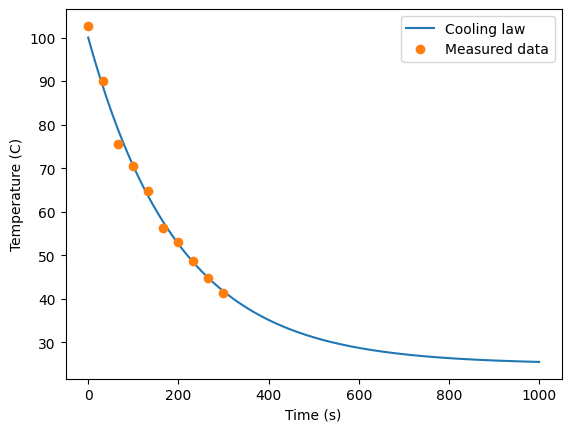

In [5]:
# Seed numpy for reproducibility
np.random.seed(10)

# Define the cooling parameters
Tenv = 25  # Ambient temperature
T0 = 100  # Starting temperature
k = 0.005  # Decay constant

# Define the full time axis of interest
times = np.linspace(0, 1000, 1000)

# Define the corresponding cooling law
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, k=k)

# Compute temperature values based on the pre-defined cooling law
temperatures = eq(times)

# Make measured data points with randomness
time_samples = np.linspace(0, 300, 10)
temperature_samples = eq(time_samples) + 2 * np.random.randn(10)

# Display the generated input that characterize the problem
plt.plot(times, temperatures)
plt.plot(time_samples, temperature_samples, "o")
plt.legend(["Cooling law", "Measured data"])
plt.ylabel("Temperature (C)")
plt.xlabel("Time (s)")

***

# <span style="color:brown"> 2) Exploit a standard neural network as optimization tool
    
As presented in the introduction to this hands-on session, you will develop a Neural Network (NN) as an optimization tool. The NN consists of a multilayer perceptron (MLP) whose optimization allows the fitting of experimental measurements.

## <span style="color:brown"> 1.1) Create a standard neural network
    
### <span style="color:red"> Instruction: </span> Run the cell below to create a neural network with a MLP architecture.
    
**Remark:** The MLP is composed of 5 layers followed by ReLU activations.

In [6]:
class Net(nn.Module):
    """Neural network with an MLP architecture."""

    # Define the constructor class with inheritance
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        n_units: int = 100,
        epochs: int = 1000,
        loss: Callable = nn.MSELoss(),
        lr: float = 1e-3,
        loss2: Callable = None,
        loss2_weight: float = 0.1,
    ) -> None:
        """Initialize class instance.

        Args:
            input_dim: Input dimension of MLP.
            output_dim: Output dimension of MLP.
            n_units: Number of neurons per hidden layer.
            epochs: Number of epochs.
            loss: Reconstruction loss function.
            lr: Learning rate.
            loss2: Optional regularization term.
            loss2_weight: Regularization weight.
        """
        super().__init__()

        # Define attributs
        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        # Define key layers which combined represents the
        # architecture of the network.
        # In our case, it corresponds to a MLP with 5 layers
        # (1x100x100x100x100x1)
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)

    def np_to_th(self, x: np.ndarray) -> torch.Tensor:
        """Convert numpy data to torch.Tensor with the selected DEVICE (cpu or gpu).

        Args:
            x: Numpy data.

        Returns:
            Converted torch.Tensor data.
        """
        n_samples = len(x)
        return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        h = self.layers(x)
        out = self.out(h)
        return out

    # Define the optimization procedure
    def optimize(self, X: np.ndarray, y: np.ndarray) -> list[float]:
        """Training loop.

        Args:
            X: Input data.
            y: Reference.

        Returns:
            List of losses over epochs.
        """
        # Convert numpy to torch Tensor
        Xt = self.np_to_th(X)
        yt = self.np_to_th(y)
        # Define the method used during optimization
        # optim.Adam is an optimizer define in PyTorch
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        # Put torch layers (batchnorm/dropout etc.) in training mode.
        self.train()
        losses = []
        # Main iteration loop to optimize the MLP parameters
        for ep in range(self.epochs):
            # At each iteration, we need to set the computed gradient to zero
            # since the call to the backward function will automatically compute
            # the NN gradients
            optimizer.zero_grad()
            # Apply the forward pass
            outputs = self.forward(Xt)
            # Compute the corresponding loss value based on the predicted outputs
            loss = self.loss(yt, outputs)
            # Update the loss value if an additional loss is defined
            if self.loss2:
                loss += self.loss2_weight * self.loss2(self)
            # Compute the backward pass
            # This step will compute the NN gradient thank to autograd concepts
            loss.backward()
            # Update the NN parameters based on the NN gradient previously computed
            # and the optimizer scheme (in this example adam)
            optimizer.step()
            # Store the value of the loss function
            losses.append(loss.item())
            # Display loss value each round(self.epochs/10) epochs
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        # Return the losses list at the end of the main loop
        return losses

    def predict(self, X: torch.Tensor) -> torch.Tensor:
        """Prediction loop."""
        # Put torch layers (batchnorm/dropout etc.) in evaluation mode.
        self.eval()

        # Disable gradient flow
        with torch.no_grad():
            # Apply the forward pass
            out = self.forward(self.np_to_th(X))
        # Return the numpy prediction detached from the computation graph
        return out.detach().cpu().numpy()

## <span style="color:brown"> 1.2) Optimize the NN to fit the measured data
    
### <span style="color:red"> Instruction: </span> Run the cell below to optimize the NN so that its outputs fit the measure data.
    
**Remark:** The fit is performed by minimizing the loss function at each epoch, by default the mean square error (i.e., nn.MSELoss)

Epoch 0/20000, loss: 4713.87
Epoch 2000/20000, loss: 2510.25
Epoch 4000/20000, loss: 2143.06
Epoch 6000/20000, loss: 727.61
Epoch 8000/20000, loss: 88.14
Epoch 10000/20000, loss: 1.57
Epoch 12000/20000, loss: 0.37
Epoch 14000/20000, loss: 0.34
Epoch 16000/20000, loss: 0.34
Epoch 18000/20000, loss: 0.33


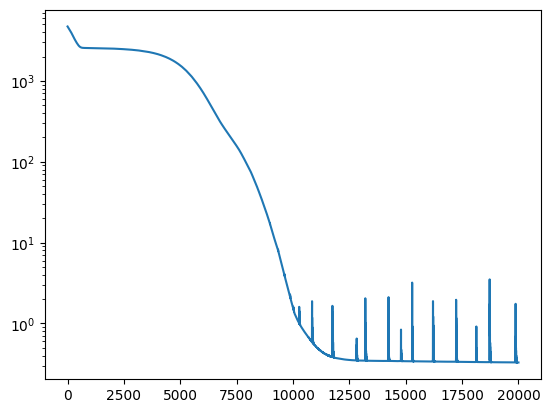

In [7]:
# Instantiate a network object from the Net class
# The ".to(DEVICE)" specifies the hardware system on
# which the NN have to be optimized
net = Net(1, 1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

# Optimize the NN
losses = net.optimize(time_samples, temperature_samples)

# Display the evolution of the loss over the epoch
# to check the good behavior of this phase, i.e., the loss must decrease
plt.plot(losses)
plt.yscale("log")

## <span style="color:brown"> 1.3) Run the NN after the optimization procedure to predict the temperatures at the full range time vector
    
### <span style="color:red"> Instruction: </span> Run the cell below to predict the temperatures at the full range time vector (outside the measured temperatures to validate the predictions of the NN).

Text(0.5, 0, 'Time (s)')

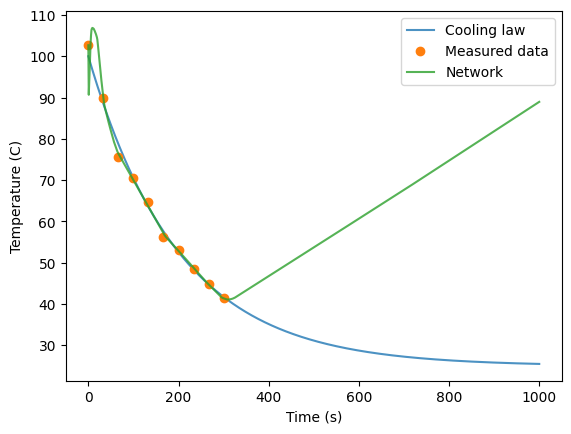

In [8]:
# Use the NN to predict the temperatures at the full range time axis
temperature_predictions = net.predict(times)

# Display the predicted results
plt.plot(times, temperatures, alpha=0.8)
plt.plot(time_samples, temperature_samples, "o")
plt.plot(times, temperature_predictions, alpha=0.8)
plt.legend(labels=["Cooling law", "Measured data", "Network"])
plt.ylabel("Temperature (C)")
plt.xlabel("Time (s)")

## <span style="color:brown"> 2.1) Constrain the standard neural network behavior with a regularization loss
    
### <span style="color:red"> Instruction: </span> Run the cell below to create an additional loss to regularize the parameters of the neural network.
    
**Remark:** The additional loss corresponds to the $L_2$ norm, i.e. $L_2=||\theta\||^2$ which forces the NN values to be as small as possible.

In [9]:
def l2_reg(model: torch.nn.Module) -> torch.Tensor:
    """L2 regularization of the model's parameters.

    Args:
        model: PyTorch model.

    Returns:
        L2 norm of the model's parameters.
    """
    return torch.sum(sum([p.pow(2.0) for p in model.parameters()]))

## <span style="color:brown"> 2.2) Optimize the $L_2$-regularized NN to fit the measured data 
    
### <span style="color:red"> Instruction: </span> Run the cell below to optimize the NN so that its output fit the measure data.
    
**Remark:** The fit is provided by minimizing the two loss functions at each epoch, i.e., nn.MSELoss + loss2_weight*loss2

Epoch 0/30000, loss: 11219.99
Epoch 3000/30000, loss: 3085.68
Epoch 6000/30000, loss: 1625.99
Epoch 9000/30000, loss: 1096.75
Epoch 12000/30000, loss: 928.71
Epoch 15000/30000, loss: 827.89
Epoch 18000/30000, loss: 728.66
Epoch 21000/30000, loss: 647.07
Epoch 24000/30000, loss: 576.38
Epoch 27000/30000, loss: 514.76


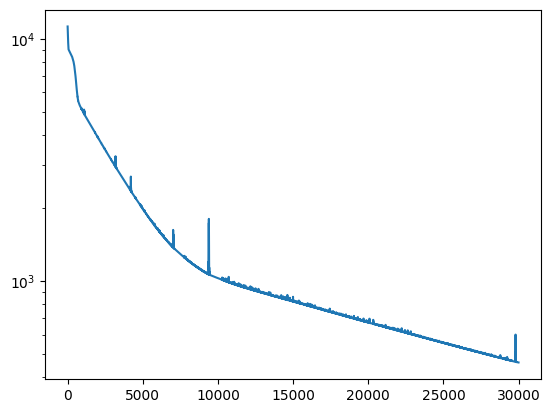

In [10]:
# Instantiate a network object from the Net class
# The ".to(DEVICE)" specifies the hardward system on
# which the NN have to be optimized
L2net = Net(1, 1, loss2=l2_reg, loss2_weight=1, epochs=30000, lr=1e-4).to(DEVICE)

# Optimize the NN
losses = L2net.optimize(time_samples, temperature_samples)

# Display the evolution of the loss over the epoch
# to check the good behavior of this phase, i.e., the loss must decrease
plt.plot(losses)
plt.yscale("log")

## <span style="color:brown"> 2.3) Run the $L_2$-regularized NN after the optimization procedure to predict the temperatures at the full range time vector
    
### <span style="color:red"> Instruction: </span> Run the cell below to predict the temperatures at the full range time vector (outside the measured temperatures to validate the predictions of the NN).

Text(0.5, 0, 'Time (s)')

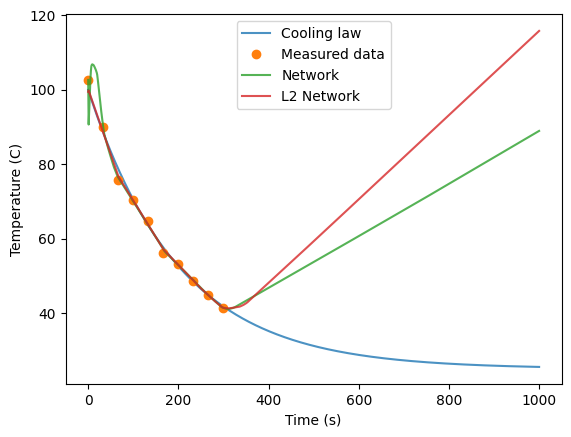

In [11]:
# Use L2-regularized NN to predict the temperatures at the full range time axis
temperature_predictions_L2 = L2net.predict(times)

# Display the predicted results
plt.plot(times, temperatures, alpha=0.8)
plt.plot(time_samples, temperature_samples, "o")
plt.plot(times, temperature_predictions, alpha=0.8)
plt.plot(times, temperature_predictions_L2, alpha=0.8)
plt.legend(labels=["Cooling law", "Measured data", "Network", "L2 Network"])
plt.ylabel("Temperature (C)")
plt.xlabel("Time (s)")

***

# <span style="color:brown"> 3) Use of Physics Informed Neural Networks (PINNs) to perform the optimization
    
We will now solve the optimization problem using PINNs. The key idea is to compute the derivatives of the outputs of the NN to compute an additional physical loss to make sure that the outputs respect the cooling law!
    
<br>
    
Here is an illustration of the general scheme of PINNs:
    
<img src="../figures/illustration_pinn.png" alt="cooling_law" style="width: 100%;"/>

## <span style="color:brown"> 3.1) Constrain the standard neural network behavior with a physics-informed loss
    
### <span style="color:red"> Instruction: </span> Run the cell below to create an additional loss to constrain the value of the neural network to impose physical regularization on the prediction output.
    
**Remark:** The additional loss corresponds to the residual of physical equation

In [12]:
# Define the gradient function that will be applied to the output of the NN
def grad(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    """Computes the partial derivative of an output with respect to an input.

    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor

    Returns:
        Derivatives of outputs w.r.t. inputs.
    """
    # It is essential to set create_graph to True to be able to manipulate the gradients afterward
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )

In [13]:
def physics_loss(model: torch.nn.Module) -> torch.Tensor:
    """Compute the physical loss.

    Args:
        model: PyTorch model.

    Returns:
        Residual loss between the estimated and real derivatives.
    """
    # Define the full time axis of interest
    # Set requires_grad to True to be able to compute the gradients w.r.t. input
    times_full = (
        torch.linspace(
            0,
            1000,
            steps=1000,
        )
        .view(-1, 1)
        .requires_grad_(True)
        .to(DEVICE)
    )
    # Compute the corresponding estimated temperature
    temperatures_full = model(times_full)
    # Compute the corresponding gradients
    dT = grad(temperatures_full, times_full)[0]
    # Compute residual loss for each temperature term
    residual = dT - k * (Tenv - temperatures_full)
    # Return residual loss
    return torch.mean(residual**2)

## <span style="color:brown"> 3.2) Optimize the PINNs to fit the measured data 
    
### <span style="color:red"> Instruction: </span> Run the cell below to optimize the PINNs so that its output fit the measure data.
    
**Remark:** The fit is provided by minimizing the two loss functions at each epoch, i.e., nn.MSELoss + physics_loss_weight * physics_loss

Epoch 0/20000, loss: 4775.84
Epoch 2000/20000, loss: 2521.76
Epoch 4000/20000, loss: 2158.78
Epoch 6000/20000, loss: 496.40
Epoch 8000/20000, loss: 5.76
Epoch 10000/20000, loss: 0.50
Epoch 12000/20000, loss: 0.55
Epoch 14000/20000, loss: 0.38
Epoch 16000/20000, loss: 0.36
Epoch 18000/20000, loss: 0.36


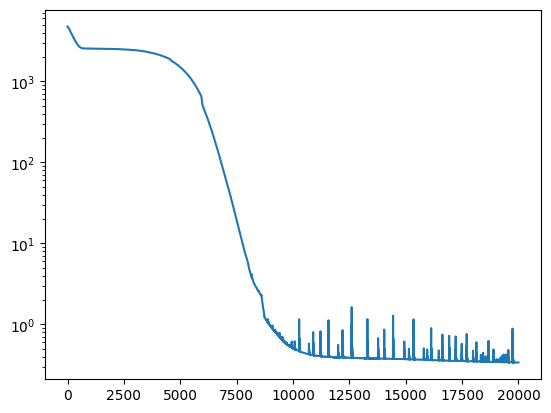

In [14]:
# Instantiate a network object from the Net class
# The ".to(DEVICE)" specifies the hardware system on
# which the PINNs have to be optimized
pinn_net = Net(1, 1, loss2=physics_loss, loss2_weight=1, epochs=20000, lr=1e-5).to(DEVICE)

# Optimize the PINNs
losses = pinn_net.optimize(time_samples, temperature_samples)

# Display the evolution of the loss over the epoch
# to check the good behavior of this phase, i.e., the loss must decrease
plt.plot(losses)
plt.yscale("log")

## <span style="color:brown"> 3.3) Run the PINNs after the optimization procedure to predict the temperatures at the full range time vector
    
### <span style="color:red"> Instruction: </span> Run the cell below to predict the temperatures at the full range time vector (outside the measured temperatures to validate the predictions of PINNs).

Text(0.5, 0, 'Time (s)')

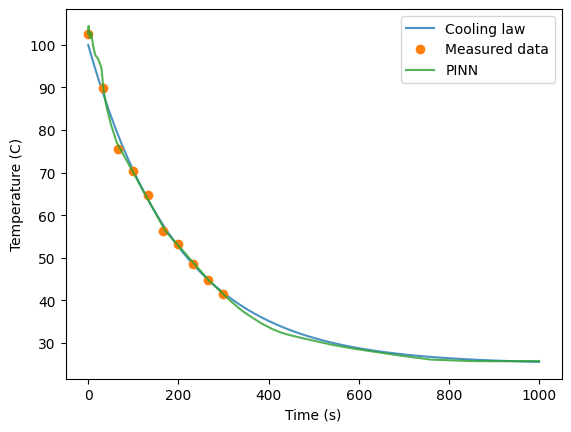

In [15]:
# Make the PINN predicts the temperature values from the full range time axis
temperature_predictions_pinn = pinn_net.predict(times)

# Display the predicted results
plt.plot(times, temperatures, alpha=0.8)
plt.plot(time_samples, temperature_samples, "o")
plt.plot(times, temperature_predictions_pinn, alpha=0.8)
plt.legend(labels=["Cooling law", "Measured data", "PINN"])
plt.ylabel("Temperature (C)")
plt.xlabel("Time (s)")

## <span style="color:brown"> 3.4) Optimize the PINN to fit the measured data 
    
### <span style="color:red"> Instruction: </span> Run the cell below to create another PINNs that optimize the decay value, $k$.
    
**Remark:** The fit is provided by minimizing the two loss functions at each epoch, i.e., nn.MSELoss + physics_loss_discovery_weight * physics_loss_discovery

In [16]:
# Definition of the neural network class
class NetDiscovery(Net):
    """Neural network with an MLP architecture.

    This network is inherited from Net and involve an additional attribute
    to estimate the optimal decay parameter.
    """

    # Define the constructor class with Net inheritance
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        n_units: int = 100,
        epochs: int = 1000,
        loss: Callable = nn.MSELoss(),
        lr: float = 1e-3,
        loss2: Callable = None,
        loss2_weight: float = 0.1,
    ) -> None:
        """Initialize class instance.

        Args:
            input_dim: Input dimension of MLP.
            output_dim: Output dimension of MLP.
            n_units: Number of neurons per hidden layer.
            epochs: Number of epochs.
            loss: Reconstruction loss function.
            lr: Learning rate.
            loss2: Optional regularization term.
            loss2_weight: Regularization weight.
        """
        super().__init__(input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight)

        # Define new attribute
        self.k = nn.Parameter(data=torch.tensor([0.0]))

## <span style="color:brown"> 3.5) Optimize the decay value, $k$ (which was a constant) during the training of PINNs
    
### <span style="color:red"> Instruction: </span> Run the cell below to create a physical loss that constrains the neural network with the optimized decay value estimated by the network.
    
**Remark:** This loss is similar to the physical loss defined in 3.1).

In [17]:
def physics_loss_discovery(model: torch.nn.Module) -> torch.Tensor:
    """Compute the physical loss with optimized decay value, k.

    Args:
        model: PyTorch model.

    Returns:
        Residual loss between the estimated and real derivatives.
    """
    # Define the full time axis of interest
    times_full = (
        torch.linspace(
            0,
            1000,
            steps=1000,
        )
        .view(-1, 1)
        .requires_grad_(True)
        .to(DEVICE)
    )
    # Compute the corresponding estimated temperature
    temperatures_full = model(times_full)
    # Compute the corresponding gradients
    dT = grad(temperatures_full, times_full)[0]
    # Compute residual loss for each temperature term
    residual = dT - model.k * (Tenv - temperatures_full)
    # Return residual loss
    return torch.mean(residual**2)

### <span style="color:red"> Instruction: </span> Run the cell below to train the PINNs to find the optimal decay value with the loss defined above.

Epoch 0/40000, loss: 4816.01
Epoch 4000/40000, loss: 2501.57
Epoch 8000/40000, loss: 2075.30
Epoch 12000/40000, loss: 559.56
Epoch 16000/40000, loss: 4.06
Epoch 20000/40000, loss: 1.27
Epoch 24000/40000, loss: 0.91
Epoch 28000/40000, loss: 0.53
Epoch 32000/40000, loss: 0.29
Epoch 36000/40000, loss: 0.18


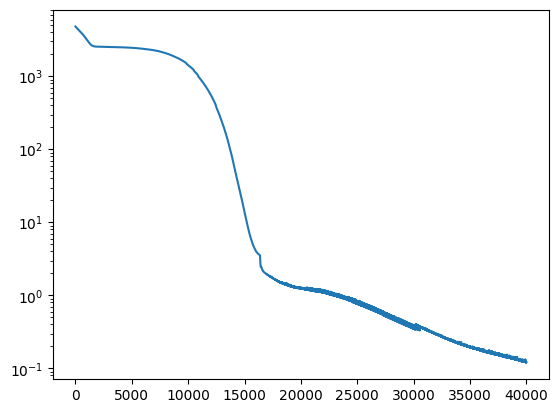

In [18]:
# Instantiate a network object from the Net class
# The ".to(DEVICE)" specifies the hardward system on
# which the PINNs have to be optimized
pinn_netdisc = NetDiscovery(
    1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr=5e-6
).to(DEVICE)

# Optimize the PINNs
losses = pinn_netdisc.optimize(time_samples, temperature_samples)

# Display the evolution of the loss over the epoch
# to check the good behavior of this phase, i.e., the loss must decrease
plt.plot(losses)
plt.yscale("log")

## <span style="color:brown"> 3.6) Run the PINNs after the optimization steps to predict the temperatures at the full range time vector
    
### <span style="color:red"> Instruction: </span> Run the cell below to predict the temperatures at the full range time vector (outside the measured temperatures to validate the predictions of the PINNs).



Decay value used in the cooling law function = 0.005
Estimated decay value = [0.00518534] 



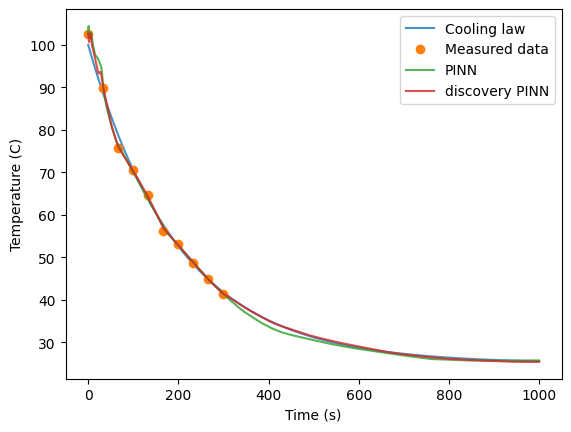

In [19]:
# Make the PINN predicts the temperature values from the full range time axis
temperature_predictions_pinn_disc = pinn_netdisc.predict(times)

# Display the predicted results
plt.plot(times, temperatures, alpha=0.8)
plt.plot(time_samples, temperature_samples, "o")
plt.plot(times, temperature_predictions_pinn, alpha=0.8)
plt.plot(times, temperature_predictions_pinn_disc, alpha=0.8)
plt.legend(labels=["Cooling law", "Measured data", "PINN", "discovery PINN"])
plt.ylabel("Temperature (C)")
plt.xlabel("Time (s)")

print("\n")
print(f"Decay value used in the cooling law function = {k}")
print(f"Estimated decay value = {pinn_netdisc.k.detach().cpu().numpy()} \n")